In [1]:
import h5py
import numpy as np
from scipy.interpolate import griddata

import matplotlib.pyplot as plt

#Set fonts
from matplotlib import rc, rcParams, cm
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Arial']})
#Use tex for math
rcParams['mathtext.fontset'] = 'cm'
rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"

In [2]:
# Functions for plotting 

def PlotLine(y = 2*56.25/25.4, x = 1.5*56.25/25.4, dpi=100):
    fig, ax = plt.subplots(figsize=(y, x), dpi=dpi, tight_layout=True)
    return ax

### Read input data

In [3]:
modelName = "FluxGB"
FName =  modelName

fileName = modelName + ".diff.in.hdf5"
fh5 = h5py.File(fileName, "r")

nSteps = fh5["SimulationParameters"]["nSteps"][()]   

fh5.close()

### Read results

In [4]:
Time = np.zeros(nSteps)
AvCon = np.zeros(nSteps)
ExFlux = np.zeros(nSteps)

fileName = modelName + ".diff.out.hdf5"
fh5 = h5py.File(fileName, "r")

for iStep in range(nSteps):
    
    Time[iStep] = fh5["Time"]["Step_"+str(iStep)][()][0]
    AvCon[iStep] = fh5["AvCon"]["Step_"+str(iStep)][()][0]
    ExFlux[iStep] = fh5["AvFlux"]["Step_"+str(iStep)][()][0]
    
fh5.close()

Text(0, 0.5, 'Average concentration (mol/m³)')

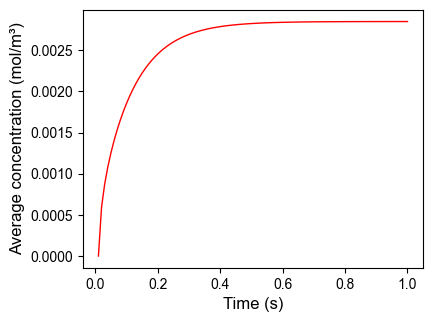

In [5]:
# Plot average concentration

ax = PlotLine()

ax.plot(Time, AvCon, lw=1, color="r")

ax.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel("Average concentration (mol/m³)", fontsize=12)

# plt.savefig("AvCon.svg")

Text(0, 0.5, 'Exit flux (mol/m²s)')

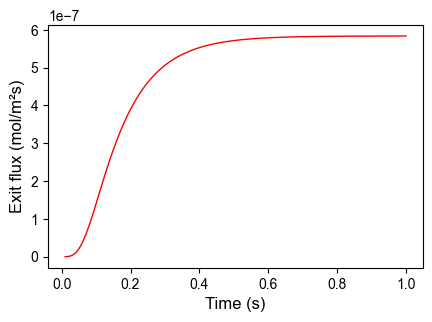

In [6]:
# Plot exit average flux 

ax = PlotLine()

ax.plot(Time, ExFlux, lw=1, color="r")

ax.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel("Exit flux (mol/m²s)", fontsize=12)

# plt.savefig("AvFlux.svg")

### Mapping concentration and flux field data to structured arrays for visualization

In [7]:
# Read node coordinates

fileName = modelName + ".mesh.hdf5"
fh5 = h5py.File(fileName, "r")

Coord = fh5["NodeCoordinates"][()]
    
fh5.close()

# Read concentrationa and flux fields  

fileName = modelName + ".diff.out.hdf5"
fh5 = h5py.File(fileName, "r")

ConField = fh5["Con"]["Step_"+str(100)][()]
FluxField = fh5["Flux"]["Step_"+str(100)][()]
    
fh5.close()

In [8]:
# Create a regular grid

nx, ny = 1000, 1000
xi = np.linspace(Coord[:,0].min(), Coord[:,0].max(), nx)
yi = np.linspace(Coord[:,1].min(), Coord[:,1].max(), ny)
X, Y = np.meshgrid(xi, yi)

In [9]:
# Map FEM results to sturctured grid

ConField2D = griddata((Coord[:,0], Coord[:,1]), ConField, (X, Y), method='linear')  # or 'cubic', 'nearest'
FluxField2D = griddata((Coord[:,0], Coord[:,1]), FluxField, (X, Y), method='linear')  # or 'cubic', 'nearest'

ConField2D = np.nan_to_num(ConField2D, nan=0.0)
FluxField2D = np.nan_to_num(FluxField2D, nan=0.0)

In [10]:
# Function for 2D field plotting

def CPlot2D(Cx, dpi=100, cmap='RdBu_r'):
                
    fig, ax = plt.subplots(1, 1, figsize=(1.5*56.25/25.4, 1.5*56.25/25.4), dpi=dpi, tight_layout=True)
    
    c = ax.contourf(Cx, 256, cmap=cmap, vmin=Cx.min(), vmax=Cx.max())
    cbar = fig.colorbar(c, ax=ax, ticks=np.linspace(Cx.min(), Cx.max(), 4), orientation="horizontal", pad=0.05)

    cbar.ax.tick_params(labelsize=8)
    ax.set_aspect('equal', 'box')
    ax.set_xticks([])
    ax.set_yticks([])

### Postprocessing fields

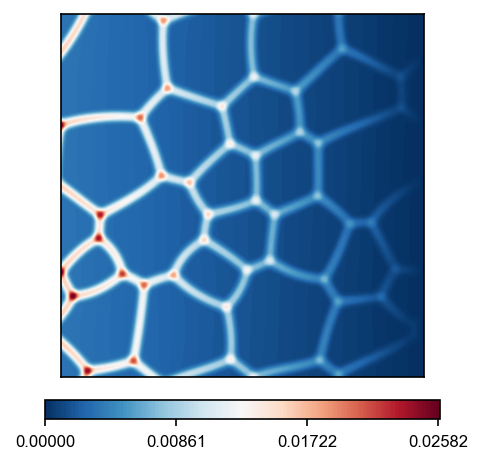

In [11]:
# Plot concentration field

CPlot2D(ConField2D, dpi=150)
# plt.savefig("ConField2D.png")

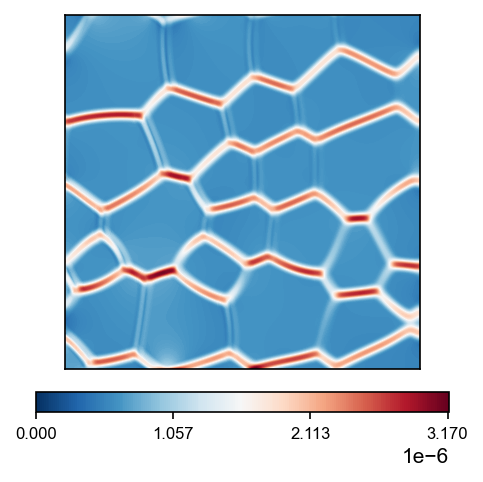

In [12]:
# Plot flux magnitude field

CPlot2D(np.sqrt(FluxField2D[:,:,0]**2 + FluxField2D[:,:,0]**2), dpi=150)
# plt.savefig("FluxField2D.png")

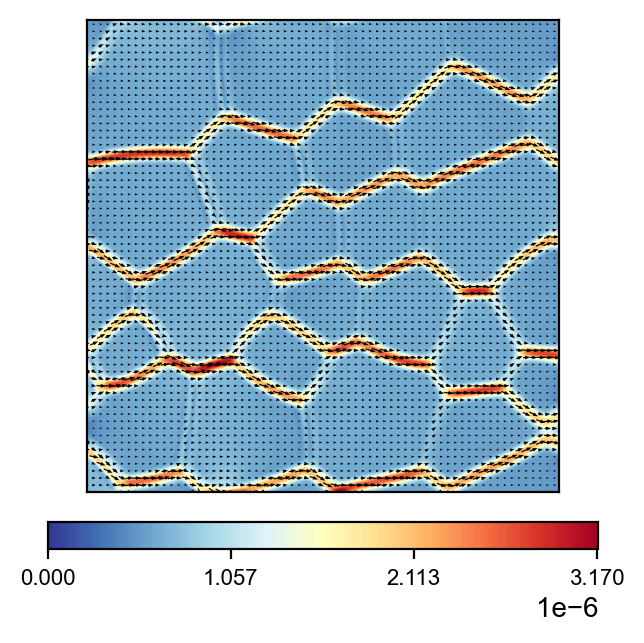

In [13]:
# Plot vector field

CPlot2D(np.sqrt(FluxField2D[:,:,0]**2 + FluxField2D[:,:,0]**2), dpi=200, cmap="RdYlBu_r")

x, y = np.meshgrid(range(nx),range(ny))
m = 15

plt.quiver(x[::m,::m], y[::m,::m], FluxField2D[::m,::m,0], FluxField2D[::m,::m,1], pivot='middle', scale_units="xy", width=0.0025, headlength=4)

# plt.savefig("FluxVectorField.png")